Tox21 The “Toxicology in the 21st Century” (Tox21) initiative created a public database measuring toxicity of compounds, which has been used in the 2014 Tox21 Data Challenge. This dataset contains qualitative toxicity measurements for 8014 compounds on 12 different targets, including nuclear receptors and stress response pathways.

Classification dataset, not regression

classification datasets are evaluated by area under curve (AUC) of the receiver operating characteristic (ROC) curve and the precision recall curve (PRC).

graph convolution provided best model?? idk how measured

12 endpoints, including 7 nuclear receptor signals (NR-AR, NR-AhR, NR-AR-LBD, NR-ER, NR-ER-LBD, NR-Aromatase, NR-PPAR-gamma) and 5 stress response indicators (SR-ARE, SR-ATAD5, SR-HSE, SR-MMP, SR-p53). In this dataset, each compound is expressed in Simplified Molecular Input Line Entry Specification (SMILES) format and the binary labels indicate whether the compound is toxic to a specific toxicological endpoint

toxicological endpoint: 1 means it is toxic to that pathway/endpoint, 0 means it isn't.

In [1]:
# %%bash
# wget https://github.com/deepchem/deepchem/blob/master/datasets/tox21.csv.gz?raw=true
# this shit not working bruh

In [2]:
%%capture
!pip install rdkit
!pip install mols2grid
!pip install --pre deepchem

In [3]:
import pandas as pd
import numpy as np
import deepchem as dc
dc.__version__
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole

from deepchem.molnet import load_tox21
from deepchem.splits import RandomSplitter
from deepchem.models.layers import GraphConv, BatchNormalization
from deepchem.models import GraphConvModel

In [20]:
# raw data
url = 'https://deepchemdata.s3.us-west-1.amazonaws.com/datasets/freesolv.csv.gz'
df = pd.read_csv(url, compression='gzip')
print(df.shape)
df

(642, 2)


,smiles,y
0,CN(C)C(=O)c1ccc(cc1)OC,-1.874467
1,CS(=O)(=O)Cl,-0.277514
2,CC(C)C=C,1.465089
3,CCc1cnccn1,-0.428367
4,CCCCCCCO,-0.105855
...,...,...
637,CCCCCCCC(=O)OC,0.458540
638,C1CCNC1,-0.436169
639,c1cc(ccc1C=O)O,-1.307471
640,CCCCCCCCl,1.064550


In [5]:
 data missing not able to be included in data
data = df.dropna()
print(data.shape)
loss = (data.shape[0]/df.shape[0]) * 100
print("Data Remaining =",loss,"%")
# drop mol_id column because its qualitative
data = data.drop('mol_id', axis=1)
data['Toxicity Score'] = data.sum(axis=1, numeric_only=True)
data

(3111, 14)
Data Remaining = 38.81956575992014 %


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles,Toxicity Score
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O=S(=O)(Cl)c1ccccc1,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(C)COC(=O)C(C)C,0.0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=C(C)C(=O)OCCOC(=O)C(=C)C,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,O=C([O-])Cc1cccc2ccccc12,1.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C#CCO,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cc1nccn1CC1CCc2c(c3ccccc3n2C)C1=O,0.0
7992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,FC(F)OC(F)(F)C(F)Cl,0.0
7996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ClCC1CO1,0.0
8001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,c1cnc(N2CCN(Cc3ccc4c(c3)OCO4)CC2)nc1,0.0


##NN Model using Fingerprint Bit Vector##

In [6]:
def SmilesToFPS(smiles):
  mol = Chem.MolFromSmiles(smiles)
  fps = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
  fps = np.array(fps)
  return fps

# splitting data
train, test = train_test_split(data, test_size = 0.1, random_state = 50)
y_train = train['Toxicity Score']
y_test = test['Toxicity Score']
X_train = np.array([SmilesToFPS(smiles) for smiles in train.smiles])
X_test = np.array([SmilesToFPS(smiles) for smiles in test.smiles])

# neural network model
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),
    Dense(128, activation='relu'),
    Dense(1, activation = 'linear'),
])

adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer ='adam',
    loss = 'mean_squared_error',
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(
    X_train,
    y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop],
)

y_test_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE =",rmse_test)

Epoch 1/30
40/40 [==============================] - 5s 44ms/step - loss: 0.6034 - val_loss: 0.4278
Epoch 2/30
40/40 [==============================] - 1s 27ms/step - loss: 0.3892 - val_loss: 0.3696
Epoch 3/30
40/40 [==============================] - 1s 16ms/step - loss: 0.2449 - val_loss: 0.3649
Epoch 4/30
40/40 [==============================] - 1s 19ms/step - loss: 0.1478 - val_loss: 0.3879
Epoch 5/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0938 - val_loss: 0.3949
Epoch 6/30
40/40 [==============================] - 1s 16ms/step - loss: 0.0681 - val_loss: 0.4058
Epoch 7/30
40/40 [==============================] - 1s 18ms/step - loss: 0.0643 - val_loss: 0.3944
Epoch 8/30
10/10 [==============================] - 0s 5ms/step
RMSE = 0.8448433584635695


88/88 [==============================] - 1s 5ms/step


Text(0, 0.5, 'Predicted Toxicity Score')

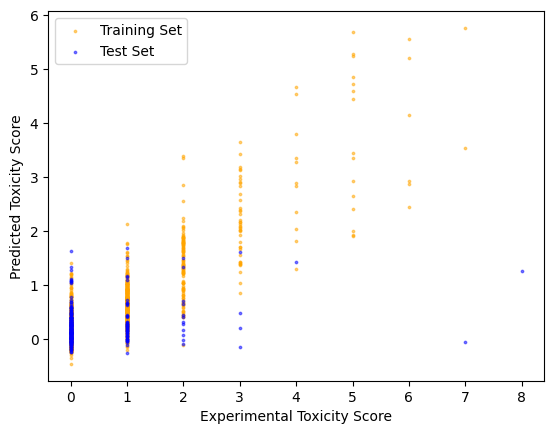

In [7]:
# evaluation of model and scatterplot
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
plt.scatter(y_train, y_train_pred, label="Training Set", color = 'orange', alpha = 0.5, s=3)
plt.scatter(y_test, y_test_pred, label="Test Set", color = 'blue', alpha = 0.5, s=3)
plt.legend()
plt.xlabel("Experimental Toxicity Score")
plt.ylabel("Predicted Toxicity Score")

# horizontal lines at around in the training set at y = -3.5, -4, -5.3

In [8]:
test["y_pred"] = y_test_pred
train["y_pred"] = y_train_pred
y_train_pred_dups = train[train.duplicated(subset = "y_pred", keep = False)]
y_train_pred_dups.sort_values(by="y_pred")

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,smiles,Toxicity Score,y_pred
5088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCN[C@H]1CCc2nc(N)sc2C1,0.0,-0.192349
2152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCN[C@H]1CCc2nc(N)sc2C1,0.0,-0.192349
1187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=CCCCCCCCCCCCC,0.0,-0.119693
2819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,C=CCCCCCCCCCC,0.0,-0.119693
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCCCCCCCCCCCCCCCBr,0.0,-0.113836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6697,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,OC[C@H](O)[C@@H](O)[C@H](O[C@@H]1O[C@H](CO)[C@...,3.0,1.040135
2611,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(C)=CCC/C(C)=C/CO,2.0,1.215911
2607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CC(C)=CCC/C(C)=C\CO,0.0,1.215911
7536,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,CC(=O)CC(c1ccccc1)c1c([O-])c2ccccc2oc1=O,2.0,3.350698


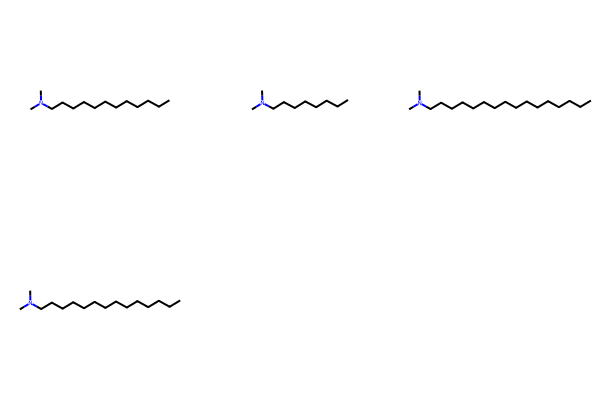

In [9]:
dup_check = y_train_pred_dups[y_train_pred_dups.y_pred == y_train_pred_dups.loc[3771, "y_pred"]]
dup_check_mols = [Chem.MolFromSmiles(smiles) for smiles in dup_check.smiles]
dup_check_mols_img = Draw.MolsToGridImage(dup_check_mols)
info = {}
dup_check_mols_fps = rdMolDescriptors.GetMorganFingerprintAsBitVect(dup_check_mols[0], 2, bitInfo = info)
tpls = [(dup_check_mols[0], x, info) for x in dup_check_mols_fps.GetOnBits()]
dup_check_mols_img

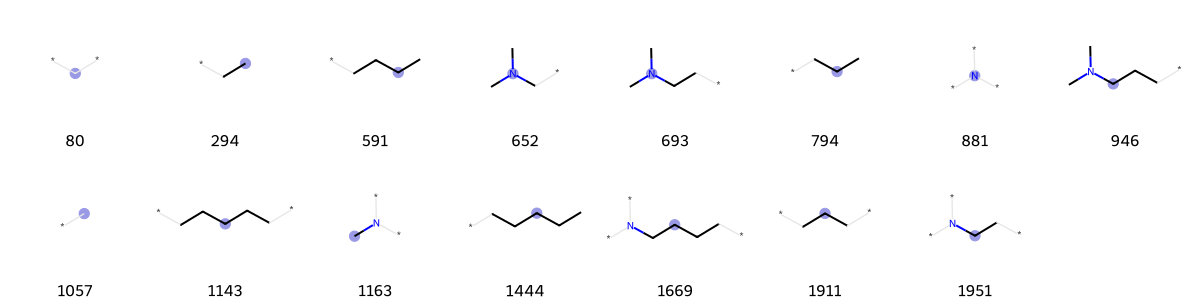

In [10]:
Draw.DrawMorganBits(tpls, molsPerRow=8, legends=[str(x) for x in dup_check_mols_fps.GetOnBits()])

In [11]:
print("Average Toxicity Score =",np.mean(y_test))
print("Standard Deviation =",np.std(y_test))
print("Root Mean Squared Error =",np.sqrt(mean_squared_error(y_test, model.predict(X_test))))

average_solubility = np.full_like(y_test, np.mean(y_train))
rmse_null_test = np.sqrt(np.mean((y_test - average_solubility)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

y_test_pred_flat = y_test_pred.flatten()
root_squared_error = np.sqrt((y_test_pred_flat - y_test)**2)
correlation = np.corrcoef(y_test, root_squared_error)[0,1]
print("Correlation =",correlation)

Average Toxicity Score = 0.3525641025641026
Standard Deviation = 0.8571306274760738
10/10 [==============================] - 0s 5ms/step
Root Mean Squared Error = 0.8448433584635695
Root Mean Squared Error Null =  0.8573795787180603
Correlation = 0.8997206711134585


##Graph Convolution##

In [12]:
tox21_tasks, tox21_datasets, transformers = load_tox21(
    featurizer='GraphConv', splitter='random')
train_dataset, valid_dataset, test_dataset = tox21_datasets
metric = dc.metrics.Metric(dc.metrics.mean_squared_error)
batch_size= 16
model= GraphConvModel(
    n_tasks = len(tox21_tasks), graph_conv_layers = [32], batch_size=batch_size, batch_normalize= True, dropout = 0.1, mode='regression')

[14:57:05] WARNING: not removing hydrogen atom without neighbors


In [13]:
model.fit(train_dataset, nb_epoch=20)
print("Evaluating model")
train_scores = model.evaluate(train_dataset, [metric], transformers)
valid_scores = model.evaluate(valid_dataset, [metric], transformers)
test_scores = model.evaluate(test_dataset, [metric], transformers)
print("Train Scores")
print(train_scores)
print("Validation Scores")
print(valid_scores)
print("Test Scores")
print(test_scores)

Evaluating model
Train Scores
{'mean_squared_error': 0.16420654973096976}
Validation Scores
{'mean_squared_error': 0.16420007895004404}
Test Scores
{'mean_squared_error': 0.18229798483930085}


0 0.14664156929679176


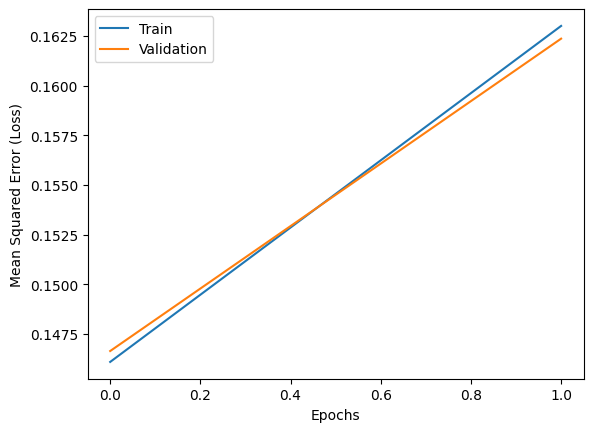

In [14]:
train_loss = []
valid_loss = []
max_epochs = 2
lowest_val = 1000
patience = 10
k = 0

for i in range(max_epochs):
  model.fit(train_dataset, nb_epoch = 2)
  train_loss_check = model.evaluate(train_dataset, [metric], transformers)
  valid_loss_check = model.evaluate(valid_dataset, [metric], transformers)
  train_loss.append(train_loss_check["mean_squared_error"])
  valid_loss.append(valid_loss_check["mean_squared_error"])
  k += 1
  if valid_loss_check["mean_squared_error"] < lowest_val:
    lowest_val = valid_loss_check["mean_squared_error"]
    print(i, lowest_val)
    k = 0
  if k == patience:
    print("Training stopped at epoch", i)
    break

plt.plot(range(len(train_loss)), train_loss, label = "Train")
plt.plot(range(len(valid_loss)), valid_loss, label = "Validation")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (Loss)")
plt.legend()

Text(0, 0.5, 'Experimental Toxicity')

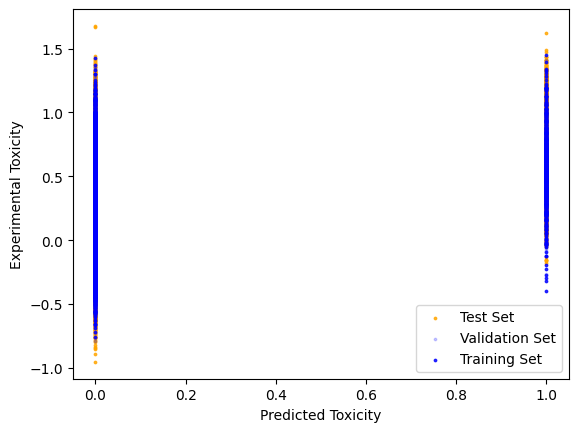

In [15]:
y_pred_train = model.predict(train_dataset)
y_train = train_dataset.y
plt.scatter(y_train, y_pred_train, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid = model.predict(valid_dataset)
y_valid = valid_dataset.y
plt.scatter(y_valid, y_pred_valid, label = "Validation Set", color = 'blue', alpha = 0.2, s = 3)

y_pred_test = model.predict(test_dataset)
y_test = test_dataset.y
plt.scatter(y_test, y_pred_test, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Toxicity")
plt.ylabel("Experimental Toxicity")

In [16]:
 y_pred_train_act = transformers[0].untransform(y_pred_train)
y_train_act = transformers[0].untransform(y_train)
plt.scatter(y_train_act, y_pred_train_act, label="Test Set", color = 'orange', alpha = 0.8, s=3)

y_pred_valid_act = transformers[0].untransform(y_pred_valid)
y_valid_act = transformers[0].untransform(y_valid)
plt.scatter(y_valid_act, y_pred_valid_act, label="Validation Set", color = 'blue', alpha = 0.2, s=3)

y_pred_test_act = transformers[0].untransform(y_pred_test)
y_test_act = transformers[0].untransform(y_test)
plt.scatter(y_test_act, y_pred_test_act, label="Training Set", color = 'blue', alpha = 0.8, s=3)

plt.legend()
plt.xlabel("Predicted Solubility")
plt.ylabel("Experimental Solubility")

NotImplementedError: ignored

In [ ]:
print("Average Solubility =",np.mean(y_test_act))
print("Standard Deviation =",np.std(y_test_act))

print("Root Mean Squared Error =",np.sqrt(np.mean((y_test_act - y_pred_test_act)**2)))

average_solubility = np.full_like(y_test_act, np.mean(y_train_act))
rmse_null_test = np.sqrt(np.mean((y_test_act - average_solubility)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

rse = np.sqrt((y_pred_test_act - y_test_act)**2)
y_test_act_squeeze = np.squeeze(np.asarray(y_test_act))
rse_squeeze = np.squeeze(np.asarray(rse))
correlation = np.corrcoef(y_test_act_squeeze, rse_squeeze)
print("Correlation=",correlation[0,1])



In [ ]:
print("Average Solubility =",np.mean(y_test))
print("Standard Deviation =",np.std(y_test))

print("Root Mean Squared Error =",np.sqrt(np.mean((y_test - y_pred_test)**2)))

average_solubility = np.full_like(y_test, np.mean(y_train))
rmse_null_test = np.sqrt(np.mean((y_test - average_solubility)**2))
print("Root Mean Squared Error Null = ", rmse_null_test)

rse = np.sqrt((y_pred_test - y_test)**2)
y_test_squeeze = np.squeeze(np.asarray(y_test))
rse_squeeze = np.squeeze(np.asarray(rse))
correlation = np.corrcoef(y_test_squeeze, rse_squeeze)
print("Correlation=",correlation[0,1])